<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter4/src/feature_generation_in_organic_materials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 有機材料の分子記述子を生成する

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、PubChem_compound_smarts_O=C(O).csvをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

## ライブラリをインポート

In [3]:
! pip install rdkit==2024.3.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 49.9 MB/s eta 0:00:00


In [12]:
import gc
import glob
import os

import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from rdkit import Chem, rdBase
from rdkit.Chem import AllChem, Descriptors, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

RDLogger.DisableLog('rdApp.*')

## データを読み込み、データフレームに格納

In [5]:
df = pd.read_csv(INPUT_FILE_PATH + "PubChem_compound_smarts_O=C(O).csv")
df

,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,...,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,4109,Methomyl,16752-77-5|Lannate|Mesomile|Methomyl|Methyl N-...,162.21,C5H10N2O2S,76.0,147.0,0.6,10,1,...,498,2D+3D,Methomyl,Agrochemical Information|Biological Test Resul...,16,425000|977599|977602|1081777|1081778|1081779|1...,20050325,3B Scientific (Wuhan) Corp|ABI Chem|Acadechem|...,Chemical Vendors|Curation Efforts|Governmental...,D004791 - Enzyme Inhibitors|D010575 - Pesticid...
1,6249,Ampicillin,69-53-4|Ampicillin|Aminobenzylpenicillin|Ampic...,349.40,C16H19N3O4S,138.0,562.0,-1.1,24,3,...,69138,2D+3D,Ampicillin,Biological Test Results|Chemical and Physical ...,16,357|361|364|368|371|373|374|375|411|422|425|42...,20050624,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,C254 - Anti-Infective Agent > C258 - Antibioti...
2,6277,Cobalt(II) acetate,Cobalt acetate|Cobalt(II) acetate|71-48-7|Coba...,177.02,C4H6CoO4,80.3,25.5,NaN,9,0,...,20991,2D,NaN,Biological Test Results|Chemical and Physical ...,14,651631|651632|651633|651634|720516|720552|7206...,20050719,3B Scientific (Wuhan) Corp|3WAY PHARM INC|ABI ...,Chemical Vendors|Curation Efforts|Governmental...,NaN
3,10112,Calcium Carbonate,Aragonite|CALCIUM CARBONATE|471-34-1|Limestone...,100.09,CCaO3,63.2,18.8,NaN,5,0,...,119575,2D,Calcium Carbonate,Agrochemical Information|Biological Test Resul...,16,1259407|1259409,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,A - Alimentary tract and metabolism > A02 - Dr...
4,36314,Paclitaxel,33069-62-4|P88XT4IS4D|Paclitaxel|Taxol|Taxol A...,853.90,C47H51NO14,221.0,1790.0,2.5,62,4,...,64277,2D,NaN,Biological Test Results|Chemical and Physical ...,15,1|3|5|7|9|11|13|15|17|19|21|23|25|27|29|31|33|...,20050326,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,C274 - Antineoplastic Agent > C186664 - Cytoto...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,60148448,Pharmakon1600-01503834,GADOTERIDOL|120066-54-8|Pharmakon1600-01503834...,559.70,C17H30GdN4O7+,134.0,494.0,NaN,29,1,...,0,2D,NaN,Biological Test Results|Chemical and Physical ...,13,1794731|1794732|1794733|1794735|1794736|179473...,20120831,DTP/NCI|ToxPlanet,Governmental Organizations|Legacy Depositors|S...,V - Various > V08 - Contrast media > V08C - Ma...
996,133562742,"(3S,5R,6R,7S,9S,12S,13S,14R)-6-[(2R,3S,4R,6S)-...",oleandomycin,687.90,C35H61NO12,166.0,1090.0,2.6,48,3,...,0,2D,Oleandomycin,Chemical and Physical Properties|Classificatio...,13,NaN,20180525,Ambinter|Wikidata,Chemical Vendors|Curation Efforts,D000890 - Anti-Infective Agents > D000900 - An...
997,134755071,"methyl (9R,10S,11S,12R,19R)-11-acetyloxy-12-et...",vincristine,825.00,C46H56N4O10,171.0,1750.0,2.8,60,3,...,0,2D,NaN,Biological Test Results|Chemical and Physical ...,13,1508598,20180905,Cheminformatics Friedrich-Schiller-University ...,Legacy Depositors|Research and Development,L - Antineoplastic and immunomodulating agents...
998,136601293,"[(7S,9Z,11S,12R,13S,14R,15R,16R,17S,18S,19Z,21...",rifampin|Rifampicin|CHEMBL1523493|PD087064,822.90,C43H58N4O12,220.0,1620.0,4.9,59,6,...,2,2D,Rifampin,Biological Test Results|Chemical and Physical ...,13,1671498,20190124,ChEMBL|Google Patents|Human Metabolome Databas...,Curation Efforts|Research and Development,D000890 - Anti-Infective Agents > D000900 - An...


## データを確認して前処理を実施

In [6]:
# dfの列名を表示
df.columns

Index([' cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea',
       'complexity', 'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds',
       'inchi', 'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname',
       'exactmass', 'monoisotopicmass', 'charge', 'covalentunitcnt',
       'isotopeatomcnt', 'totalatomstereocnt', 'definedatomstereocnt',
       'undefinedatomstereocnt', 'totalbondstereocnt', 'definedbondstereocnt',
       'undefinedbondstereocnt', 'pclidcnt', 'gpidcnt', 'gpfamilycnt',
       'neighbortype', 'meshheadings', 'annothits', 'annothitcnt', 'aids',
       'cidcdate', 'sidsrcname', 'depcatg', 'annotation'],
      dtype='object')

In [7]:
# dfから'cmpdname'と'canonicalsmiles'のみを抽出
df = df[["cmpdname", "canonicalsmiles"]]
df

,cmpdname,canonicalsmiles
0,Methomyl,CC(=NOC(=O)NC)SC
1,Ampicillin,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...
2,Cobalt(II) acetate,CC(=O)[O-].CC(=O)[O-].[Co+2]
3,Calcium Carbonate,C(=O)([O-])[O-].[Ca+2]
4,Paclitaxel,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...
...,...,...
995,Pharmakon1600-01503834,CC(CN1CCN(CCN(CCN(CC1)CC(=O)[O-])CC(=O)[O-])CC...
996,"(3S,5R,6R,7S,9S,12S,13S,14R)-6-[(2R,3S,4R,6S)-...",CC1CC(C(C(O1)OC2C(CC3(CO3)C(=O)C(C(C(C(OC(=O)C...
997,"methyl (9R,10S,11S,12R,19R)-11-acetyloxy-12-et...",CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...
998,"[(7S,9Z,11S,12R,13S,14R,15R,16R,17S,18S,19Z,21...",CC1C=CC=C(C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=...


## SMILES から ROMol オブジェクトを生成

,cmpdname,canonicalsmiles,ROMol
0,Methomyl,CC(=NOC(=O)NC)SC,
1,Ampicillin,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,
2,Cobalt(II) acetate,CC(=O)[O-].CC(=O)[O-].[Co+2],
3,Calcium Carbonate,C(=O)([O-])[O-].[Ca+2],
4,Paclitaxel,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,
...,...,...,...
995,Pharmakon1600-01503834,CC(CN1CCN(CCN(CCN(CC1)CC(=O)[O-])CC(=O)[O-])CC...,
996,"(3S,5R,6R,7S,9S,12S,13S,14R)-6-[(2R,3S,4R,6S)-...",CC1CC(C(C(O1)OC2C(CC3(CO3)C(=O)C(C(C(C(OC(=O)C...,
997,"methyl (9R,10S,11S,12R,19R)-11-acetyloxy-12-et...",CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,
998,"[(7S,9Z,11S,12R,13S,14R,15R,16R,17S,18S,19Z,21...",CC1C=CC=C(C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=...,

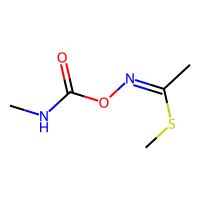
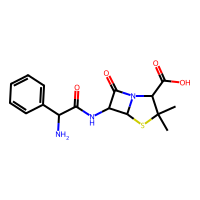
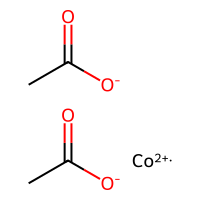
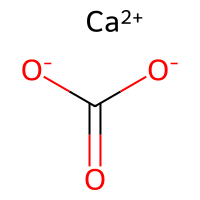
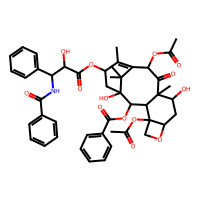
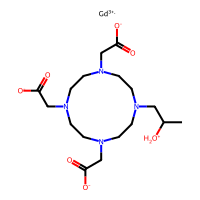
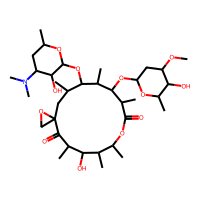
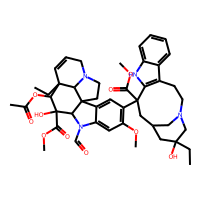
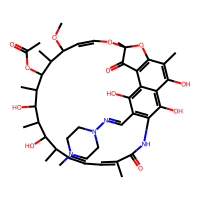
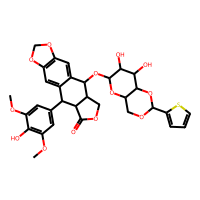

In [8]:
PandasTools.AddMoleculeColumnToFrame(df, "canonicalsmiles")
df

## ROMol オブジェクトから分子記述子を生成

,cmpdname,canonicalsmiles,ROMol,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Methomyl,CC(=NOC(=O)NC)SC,,10.382504,10.382504,0.547778,-0.547778,0.271082,10.900000,162.214,...,1,0,0,0,0,0,0,0,0,0
1,Ampicillin,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,,12.334173,12.334173,0.374515,-1.033228,0.674878,28.708333,349.412,...,1,0,0,0,0,0,0,0,0,0
2,Cobalt(II) acetate,CC(=O)[O-].CC(=O)[O-].[Co+2],,8.888889,8.888889,0.000000,-1.083333,0.409563,5.555556,177.021,...,0,0,0,0,0,0,0,0,0,0
3,Calcium Carbonate,C(=O)([O-])[O-].[Ca+2],,8.333333,8.333333,0.000000,-2.333333,0.308163,4.800000,100.086,...,0,0,0,0,0,0,0,0,0,0
4,Paclitaxel,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,,15.483795,15.483795,0.002885,-2.390958,0.129786,31.854839,853.918,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Pharmakon1600-01503834,CC(CN1CCN(CCN(CCN(CC1)CC(=O)[O-])CC(=O)[O-])CC...,,11.024428,11.024428,0.000000,-1.249440,0.262120,20.068966,559.698,...,0,0,0,0,0,0,0,0,0,0
996,"(3S,5R,6R,7S,9S,12S,13S,14R)-6-[(2R,3S,4R,6S)-...",CC1CC(C(C(O1)OC2C(CC3(CO3)C(=O)C(C(C(C(OC(=O)C...,,13.881184,13.881184,0.198241,-1.095135,0.274195,49.854167,687.868,...,0,0,0,0,0,0,0,0,0,0
997,"methyl (9R,10S,11S,12R,19R)-11-acetyloxy-12-et...",CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,,15.321994,15.321994,0.155289,-2.531098,0.131025,36.466667,824.972,...,0,0,0,0,0,0,0,0,0,0
998,"[(7S,9Z,11S,12R,13S,14R,15R,16R,17S,18S,19Z,21...",CC1C=CC=C(C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=...,,14.425630,14.425630,0.055940,-2.042566,0.109485,30.101695,822.953,...,0,0,0,0,0,0,0,0,0,0

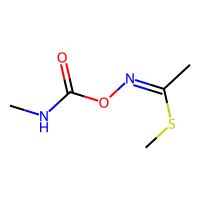
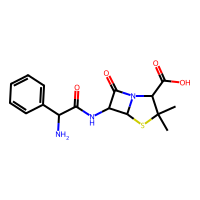
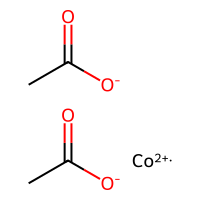
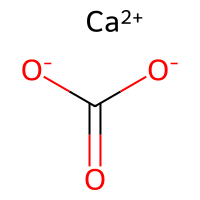
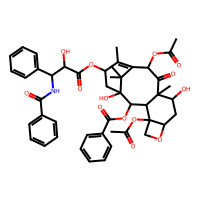
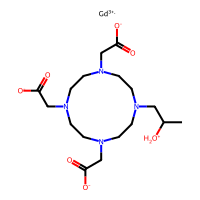
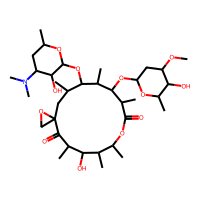
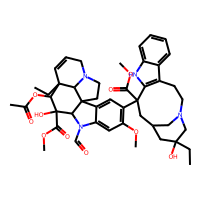
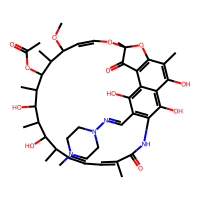
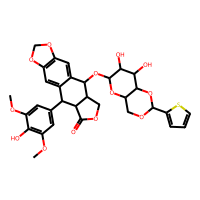

In [9]:
# RDKit記述子を計算
for i, j in Descriptors.descList:
    df[i] = df.ROMol.map(j)

df

## 分子記述子の中身、数を確認

In [11]:
len(Descriptors.descList)

210

In [13]:
descriptor_names = [desc_name for desc_name, _ in Descriptors.descList]
descriptor_names

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',


In [15]:
# 欠損値を含む行を削除
df = df.dropna()
df

,cmpdname,canonicalsmiles,ROMol,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Methomyl,CC(=NOC(=O)NC)SC,<rdkit.Chem.rdchem.Mol object at 0x7c0cdf38ff40>,10.382504,10.382504,0.547778,-0.547778,0.271082,10.900000,162.214,...,1,0,0,0,0,0,0,0,0,0
1,Ampicillin,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,<rdkit.Chem.rdchem.Mol object at 0x7c0cdf38e1f0>,12.334173,12.334173,0.374515,-1.033228,0.674878,28.708333,349.412,...,1,0,0,0,0,0,0,0,0,0
4,Paclitaxel,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7c0cdf38f1b0>,15.483795,15.483795,0.002885,-2.390958,0.129786,31.854839,853.918,...,0,0,0,0,0,0,0,0,0,0
5,L-Tartaric acid,C(C(C(=O)O)O)(C(=O)O)O,<rdkit.Chem.rdchem.Mol object at 0x7c0cdf38f680>,9.771852,9.771852,1.768611,-2.266204,0.365229,15.800000,150.086,...,0,0,0,0,0,0,0,0,0,0
6,Isotretinoin,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,<rdkit.Chem.rdchem.Mol object at 0x7c0cdf38edc0>,10.534005,10.534005,0.259688,-0.912324,0.529573,20.227273,300.442,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,(6E)-7-[3-(4-fluorophenyl)-1-(propan-2-yl)-1H-...,CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)O)O)O)C3=...,<rdkit.Chem.rdchem.Mol object at 0x7c0cdec6e1f0>,13.498317,13.498317,0.072829,-1.129930,0.504788,13.933333,411.473,...,0,0,0,0,0,0,0,0,0,0
996,"(3S,5R,6R,7S,9S,12S,13S,14R)-6-[(2R,3S,4R,6S)-...",CC1CC(C(C(O1)OC2C(CC3(CO3)C(=O)C(C(C(C(OC(=O)C...,<rdkit.Chem.rdchem.Mol object at 0x7c0cdec6e2d0>,13.881184,13.881184,0.198241,-1.095135,0.274195,49.854167,687.868,...,0,0,0,0,0,0,0,0,0,0
997,"methyl (9R,10S,11S,12R,19R)-11-acetyloxy-12-et...",CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,<rdkit.Chem.rdchem.Mol object at 0x7c0cdec6e340>,15.321994,15.321994,0.155289,-2.531098,0.131025,36.466667,824.972,...,0,0,0,0,0,0,0,0,0,0
998,"[(7S,9Z,11S,12R,13S,14R,15R,16R,17S,18S,19Z,21...",CC1C=CC=C(C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=...,<rdkit.Chem.rdchem.Mol object at 0x7c0cdec6e3b0>,14.425630,14.425630,0.055940,-2.042566,0.109485,30.101695,822.953,...,0,0,0,0,0,0,0,0,0,0


## OCSVMを使用したモデル適用範囲の検討

In [17]:
# 前半500個をtrain_df、残りをtest_dfとする
train_df = df[:500]
test_df = df[500:]

In [18]:
# スケーラーを定義
scaler_x = StandardScaler()
# スケーラーを適用
scaler_x.fit(train_df[descriptor_names])
X_train = scaler_x.transform(train_df[descriptor_names])
X_test = scaler_x.transform(test_df[descriptor_names])

In [43]:
nu = 0.03 # train_dfに3%、大多数とは異なる素性のデータが含まれると仮定する
model = OneClassSVM(kernel='rbf', nu=nu)
model.fit(X_train)

OneClassSVM(nu=0.03)

In [44]:
pred = model.predict(X_test)

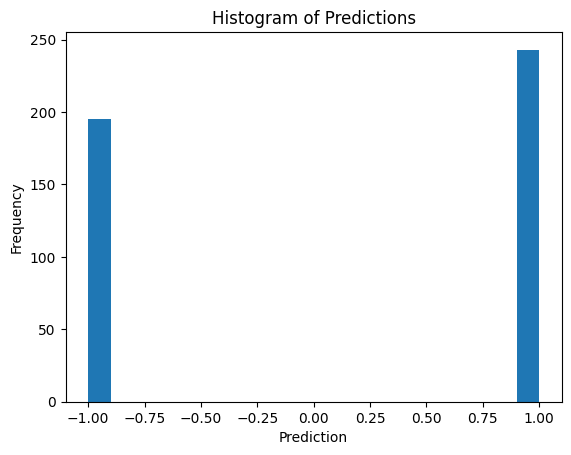

In [45]:
# 予測値が「1」であれば学習データと似た特徴を持つ水準と判定、「0」であれば学習データと似ていない特徴を持つ水準と判定
# 言い換えると、「1」であれば学習データで構築する機械学習モデルのモデル適用範囲内、「0」であればモデル適用範囲外と考える
plt.hist(pred, bins=20)
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions')
plt.show()

## 実行環境のライブラリverを保存

In [46]:
# Pythonのverを確認
!python3 -V

Python 3.11.11


In [47]:
!pip freeze > requirements_feature_generation_in_organic.txt

In [48]:
from google.colab import files

files.download('requirements_feature_generation_in_organic.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>